## Simulate production-degradation process for long duration

In [1]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

duration = 10000 
L=cbrt(100)
Ca=5.
Cb=1.
k0= 0.1

def write(name,obs):
    f=open(name,'w')
    data = np.array(obs.data()).T
    np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
    f.close()        
    print('saving into',name)        

def singlerun_spa(rm,D):   #Spatiocyte solver
    V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm*1.0208582)    
    Nb=int(Cb*V)
    Na=int(Ca*V)
    keff = k0/(Nb/V)/(Na/V)
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    dt = (2*rm*1.0208582)**2 / (6*D)
    assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm*1.0208582  }
        B | {'D': D, 'radius':rm*1.0208582  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | ka
    m = get_model()
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rm*1.0208582)
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = spatiocyte.SpatiocyteSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_bd_{}_rm{:.3}_D{:.3}_L{:.3}b_dur{}'.format('spa',rm,D,L,duration),obs)
    return obs

def singlerun_e(rm,D): #egfrd solver
    V = L**3 
    keff = k0/Ca/Cb
    Nb=100
    Na=500
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    dt = (2*rm)**2 / (6*D)
    M = max(int(min(cbrt(Na + Nb), L / (2 * rm))), 3)
    assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm  }
        B | {'D': D, 'radius':rm  }

    with reaction_rules():
        ~A > A | k0
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    w = egfrd.EGFRDWorld(Real3(L,L,L),Integer3(M,M,M))
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = egfrd.EGFRDSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_bd_{}_rm{:.3}_D{:.3}_L{:.3}b_dur{}'.format('egfrd',rm,D,L,duration),obs)
    return obs

def singlerun_g(rm,D): #gillespie solver
    K=int(L/2/rm)
    V = L**3 
    Nb=100
    Na = 500
    dt = (2*rm)**2 / (6*D)
    keff = k0/Ca/Cb
    with species_attributes():
        A | {'D': D}
        B | {'D': D}

    with reaction_rules():
        ~A > A | k0
        A + B >B | keff
    m = get_model()
    w = gillespie.GillespieWorld(Real3(L,L,L))
    w.bind_to(m)
    w.add_molecules(Species('B'),Nb)
    w.add_molecules(Species('A'),Na)
    sim = gillespie.GillespieSimulator(w)    
    obs = FixedIntervalNumberObserver(dt, ['A'])
    sim.run(duration,obs)
    data = np.array(obs.data()).T
    #write('/home/chew/outputdata/sturrock_gillespie_rm{:.3}_D{:.3}_L{:.3}_dur{}'.format(rm,D,L,duration),obs)
    return obs

#insert molecule radius/voxel radius and diffusion coefficient
r=0.05
D=0.1
obs_spa=singlerun_spa(r,D)
obs_e=singlerun_e(r,D)
obs_g=singlerun_g(r,D)

D=0.02
obs_spa=singlerun_spa(r,D)
obs_e=singlerun_e(r,D)


### Generate histogram from time series data

Gillespie
4.9713995599 0.0387678366686
Spatiocyte
4.96558538572 0.0416762566531
eGFRD
4.94977077314 0.0445914574202
Spatiocyte
4.78908629107 0.0424461104944
eGFRD
4.76841887761 0.0436854796588
RDMEm
4.71765932572 0.0460792160362


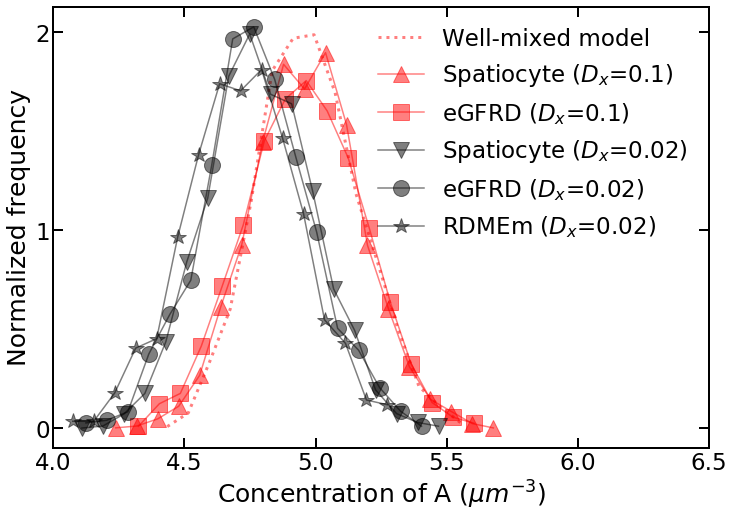

In [4]:
from ecell4 import *
from math import pi as pi
import math
import numpy as np
import matplotlib.pylab as plt
from scipy import special
%matplotlib inline

fig,ax1=plt.subplots(1,1,figsize=(10,7))
plt.tight_layout(pad=0)
fs=23
ms=16
lw=3
#ls=['-','--',':','-.',(0, (3, 5, 1, 5, 1, 5))]
ls=['^','s','v','o','P','*']

def getc(rm,D,L,sim,dur,kk):
    if D==0.02: c='k'
    else: c='r'
    if (sim=='Spatiocyte'):
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),1.0208582*rm)  
        d=np.genfromtxt('data/pd_spa_rm{}_D{}_L{}b_dur{}'.format(rm,D,L,dur),delimiter=',')    
    elif (sim=='eGFRD'): 
        V=L**3
        d=np.genfromtxt('data/pd_egfrd_rm{}_D{}_L{}b_dur{}'.format(rm,D,L,dur),delimiter=',')    
    elif (sim=='Gillespie'):
        V=L**3
        d=np.genfromtxt('data/pd_gillespie_rm{}_D{}_L{}_dur{}'.format(rm,D,L,dur),delimiter=',')            
    else:
        V=L**3
        d=np.genfromtxt('data/pd_meso_rm{}_D{}_L{}_dur{}'.format(rm,D,L,dur),delimiter=',')    
    
    ll= d.shape[0]
    con=((d[:,1][int(ll*0.3):])/V)
    ave=np.mean(con)
    noise=np.std(con)/ave
    print(sim)
    print(ave,noise)
    hi,be=np.histogram(con,bins=np.arange(min(con),max(con),0.08),normed=True)
    if (sim=='Gillespie'):
        ax1.plot((be[1:]+be[:-1])*0.5,hi,':',label='Well-mixed model',linewidth=lw,markersize=ms,color=c,alpha=0.5)
    elif (sim=='eGFRD'): 
        ax1.plot((be[1:]+be[:-1])*0.5,hi,marker=ls[kk],label=sim+' ($D_x$='+str(D)+')',markersize=ms,color=c,alpha=0.5)
    elif (sim=='Spa.'): 
        ax1.plot((be[1:]+be[:-1])*0.5,hi,marker=ls[kk],label=sim+' ($D_x$='+str(D)+')',markersize=ms,color=c,alpha=0.5)
    else:
        ax1.plot((be[1:]+be[:-1])*0.5,hi,marker=ls[kk],label=sim+' ($D_x$='+str(D)+')',markersize=ms,color=c,alpha=0.5)
    return 


#fig,ax1=plt.subplots(1,1,figsize=(12,8))
getc(0.5,0.1,4.64,'Gillespie',10000,4)
getc(0.05,0.1,4.64,'Spatiocyte',50000,0)
getc(0.05,0.1,4.64,'eGFRD',10000,1)
getc(0.05,0.02,4.64,'Spatiocyte',50000,2)
getc(0.05,0.02,4.64,'eGFRD',5000,3)
getc(1.0,0.02,4.64,'RDMEm',50000,5)

ax1.set_xlim(4,6.5)
ax1.legend(fontsize=fs,frameon=False,loc='best')
ax1.tick_params(labelsize=fs)
ax1.set_xlabel('Concentration of A $(\mu m^{-3})$',fontsize=fs+2)
ax1.set_ylabel('Normalized frequency',fontsize=fs+2)
ax1.locator_params(axis='y', nbins=4)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='both',which='both',direction='in',length=10,width=2)
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
fig.tight_layout(pad=0)        